<table style="color:red">
    <thead>
        <tr><th>E1</th><th>E2</th><th>E3</th><th>E4</th><th>E5</th><th>E6</th><th>E7</th><th>E8</th><th>E9</th><th>Total</th></tr>
    </thead>
    <tbody>
        <tr>
            <td>1</td>
            <td>1</td>
            <td>0</td>
            <td>0.5</td>
            <td>0.5</td>
            <td>1</td>
            <td>1</td>
            <td>2</td>
            <td>1</td>
            <td>8</td>
        </tr>
    </tbody>
</table>

# Exercises set 4
### By Ulzii-Utas & Guillem Boada

In [34]:
# SETUP
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics, cross_validation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from scipy import stats
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Logistic regression

#### 1. Read EEG_data.csv into a DataFrame.

In [35]:
df_raw = pd.read_csv('EEG_data.csv')
df_raw.head() # show the raw DataFrame

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


#### 2. Change type of `SubjectID` and `VideoID` to integer.

In [36]:
df_raw['SubjectID'] = df_raw.SubjectID.astype(int)
df_raw['VideoID'] = df_raw.VideoID.astype(int)

# View updated types to show the success of the change
# print(df_raw.dtypes)

#### 3. Group by `SubjectID` and `VideoID` taking the median.

In [37]:
df_grouped = df_raw.groupby(['SubjectID','VideoID']).median()
df_grouped.head() # show the summarised DataFrame

Attention  Mediation   Raw     Delta     Theta   Alpha1  \
SubjectID VideoID                                                            
0         0             57.0       53.0  41.0  304329.0   81382.5  13622.0   
          1             47.0       50.0  33.0  578197.0  109448.0  23867.5   
          2             43.5       48.0   7.5  463542.0   96455.0  18521.0   
          3             52.0       53.0  37.0  471965.5   64971.0  15899.5   
          4             53.0       47.0  28.0  301557.0   45817.5  14845.5   

                    Alpha2    Beta1    Beta2   Gamma1   Gamma2  \
SubjectID VideoID                                                
0         0        14065.5  14312.5  33887.5  29328.5  13104.5   
          1        16974.5  18187.0  31988.0  29606.5  10958.5   
          2        13002.0  14092.5  30222.0  27109.0  10977.5   
          3        12748.5  11729.0  33487.5  31548.0  11812.5   
          4        10775.5  13702.0  31554.0  28606.0  11745.5   

                   predefinedlabel  user-definedlabeln  
SubjectID VideoID                                       
0         0                    0.0                 0.0  
          1                    0.0                 1.0  
          2                    0.0                 1.0  
          3                    0.0                 0.0  
          4                    0.0                 0.0

#### 4. Rename and change type of `predefinedlabel` and `user-definedlabeln`.

In [38]:
df_grouped = df_grouped.rename(columns={'predefinedlabel': 'ExpectedConfusion', 'user-definedlabeln': 'ReportedConfusion'})

# Change type of "SubjectID" and "VideoID" to integer
df_grouped['ExpectedConfusion'] = df_grouped.ExpectedConfusion.astype(int)
df_grouped['ReportedConfusion'] = df_grouped.ReportedConfusion.astype(int)

# View updated types to show the success of the change
# print(df_grouped.dtypes)

### Explore data:

In [39]:
df_grouped.iloc[20:30]

Attention  Mediation   Raw    Delta    Theta  Alpha1  \
SubjectID VideoID                                                         
2         0             60.5       51.0  32.0   9309.5  10854.0  4970.5   
          1             56.0       60.5  33.5  12534.5  12490.0  6545.0   
          2             63.0       66.5  33.0   9583.0   9507.5  5972.5   
          3             44.0       64.0  36.5   7193.0  10929.0  5199.0   
          4             66.0       60.5  34.0   8090.0  13133.5  6682.0   
          5             78.0       64.0  35.0   9804.0  15638.0  6829.0   
          6             56.0       55.0  34.0   7258.0   9668.5  4397.0   
          7             47.0       60.0  33.0  12879.0  14316.0  6634.0   
          8             57.0       61.0  36.0   8802.0  10310.0  4509.0   
          9             43.0       64.0  32.0   8343.0  10231.0  5203.0   

                   Alpha2    Beta1    Beta2  Gamma1  Gamma2  \
SubjectID VideoID                                             
2         0        5131.0   4707.5   5848.5  2945.5  2379.5   
          1        6625.0   5047.5   6313.5  3125.5  2239.5   
          2        6542.5   5260.5   5416.0  2596.0  1923.0   
          3        4804.0   4940.5   4756.0  2500.0  1543.0   
          4        9777.5  11025.5  15876.0  9354.0  6916.0   
          5        7689.0   9777.0  10640.0  5818.0  3848.0   
          6        4937.0   4809.5   5700.5  2510.0  2147.5   
          7        5959.0   7260.0   8529.0  5367.0  4454.0   
          8        5294.0   5553.0   5672.0  2752.0  2292.0   
          9        6331.0   4917.0   5080.0  2211.0  1779.0   

                   ExpectedConfusion  ReportedConfusion  
SubjectID VideoID                                        
2         0                        0                  0  
          1                        0                  1  
          2                        0                  0  
          3                        0                  0  
          4                        0                  1  
          5                        1                  1  
          6                        1                  0  
          7                        1                  1  
          8                        1                  1  
          9                        1                  0

Recalling homework 3, we explore the data for Subject 6, which we could not use because the values for `Attention` and `Mediation` were all set to zero.

In [40]:
df_grouped.iloc[61:70]

Attention  Mediation     Raw     Delta     Theta   Alpha1  \
SubjectID VideoID                                                              
6         1              0.0        0.0  1947.0  508054.0  156218.5  27241.5   
          2              0.0        0.0  2047.0  493472.0  140408.0  24574.0   
          3              0.0        0.0   745.0  710475.0  251334.0  79509.0   
          4              0.0        0.0  2047.0  586601.0  155210.0  32401.5   
          5              0.0        0.0  2047.0  564779.0  120484.0  20605.0   
          6              0.0        0.0  2047.0  672645.0  149628.5  21056.0   
          7              0.0        0.0  1996.0  552618.0  127639.0  22642.0   
          8              0.0        0.0  1440.0  823137.0  220264.5  50082.0   
          9              0.0        0.0  1864.0  745014.0  158270.0  30518.0   

                    Alpha2    Beta1     Beta2    Gamma1   Gamma2  \
SubjectID VideoID                                                  
6         1        30590.0  35735.5  229804.0  210639.0  56004.5   
          2        25138.5  27305.5  229283.5  172220.0  47531.5   
          3        89988.0  63536.5   80381.0   64521.0  67986.5   
          4        29148.0  41267.5  267640.5  216531.5  66907.0   
          5        34218.0  32353.0   66513.0   48064.0  25101.0   
          6        43108.5  41244.5  123349.0   85899.0  45283.5   
          7        28895.0  31902.0   39863.0   36320.0  25035.0   
          8        75637.0  41083.0   74182.5   54261.0  58468.5   
          9        43138.0  31612.0   42248.0   43991.0  32345.0   

                   ExpectedConfusion  ReportedConfusion  
SubjectID VideoID                                        
6         1                        0                  0  
          2                        0                  0  
          3                        0                  1  
          4                        0                  1  
          5                        1                  0  
          6                        1                  1  
          7                        1                  0  
          8                        1                  1  
          9                        1                  0

Just observing the values for the `Raw` EEG, we see that the recording did not work, as the magnitude of the EEG signal should be around a few dozen microvolts, but for Subject 6 they are too high (1900, 2000, etc.). So, as the frenquency band powers are computed from this `Raw`, they will also be wrong.

**We decide to drop Subject 6 because it would spoil our model.**

In [41]:
df=df_grouped.drop(6)
df.iloc[55:65] # check that Subject 6 observations have been droped

Attention  Mediation   Raw     Delta     Theta   Alpha1  \
SubjectID VideoID                                                            
5         5             44.0       56.0  24.0  668549.0  141976.0  31541.0   
          6             44.0       61.0  24.5  778760.5  192265.5  44257.5   
          7             48.0       53.0  25.0  506001.0   95566.0  20047.0   
          8             42.0       49.0  10.5  771479.0  176048.5  29152.0   
          9             44.0       57.0  36.5  304725.0   87659.0  18548.0   
7         0             47.0       44.0  29.5  388171.0   70540.0  13229.0   
          1             40.0       53.0  34.0  693471.5   93714.5  21508.0   
          2             60.5       51.0  23.5   70079.5   31634.5  10848.5   
          3             20.5       56.0  44.5  800065.5  138929.5  27282.5   
          4             50.0       47.0  35.0  210488.5   55984.0  13261.0   

                    Alpha2    Beta1    Beta2   Gamma1   Gamma2  \
SubjectID VideoID                                                
5         5        21076.0  21446.0  18893.0   9298.0   3346.0   
          6        30446.5  27040.0  18207.0  11028.5   4276.5   
          7        16329.0   9231.0  11310.0   7642.0   1360.0   
          8        21144.5  19859.0  13513.0   6658.0   2695.5   
          9        14065.5   7133.0  10001.5   6942.5   1165.0   
7         0        13597.0  16197.5  32396.0  23462.0  17597.5   
          1        16549.0  11346.0  17963.5  14239.0  11005.0   
          2        11168.5  13889.5  20315.0  12822.0  10618.0   
          3        17721.5  13199.0  12578.5  12801.0   8158.5   
          4        12799.0  14175.5  23876.0  15872.0  12662.0   

                   ExpectedConfusion  ReportedConfusion  
SubjectID VideoID                                        
5         5                        1                  1  
          6                        1                  1  
          7                        1                  0  
          8                        1                  1  
          9                        1                  0  
7         0                        0                  1  
          1                        0                  1  
          2                        0                  0  
          3                        0                  1  
          4                        0                  1

### E1. Is there class imbalance?

In [42]:
# Explore the response variables 'ExpectedConfusion' and 'ReportedConfusion'
targets = ['ExpectedConfusion','ReportedConfusion']
df[targets].iloc[0:10] # show the targets values for Subject 0

ExpectedConfusion  ReportedConfusion
SubjectID VideoID                                      
0         0                        0                  0
          1                        0                  1
          2                        0                  1
          3                        0                  0
          4                        0                  0
          5                        1                  1
          6                        1                  1
          7                        1                  0
          8                        1                  1
          9                        1                  0

The `ExpectedConfusion` is predefined for each video:
* **Videos 0 - 4:**  clear, `ExpectedConfusion` = 0.
* **Videos 5 - 9:**  confusing, `ExpectedConfusion` = 1.

We can already conclude that the target `ExpectedConfusion` is balanced (50:50), as it is predefined this way by the experiment design.

The `ReportedConfusion` is given by the student after watching the video, so it may be imbalanced. Let's check it:

In [43]:
# Reconfirm that 'ExpectedConfusion' is balanced
df['ExpectedConfusion'].value_counts()

1    45
0    45
Name: ExpectedConfusion, dtype: int64

In [44]:
# Check if 'ReportedConfusion' is balanced
df['ReportedConfusion'].value_counts()

1    46
0    44
Name: ReportedConfusion, dtype: int64

The data for `ExpectedConfusion` is luckly very balanced!

### E2. Logistic regression. Training accuracy.

#### Select predictors and target

In [45]:
# Select the target 
target = 'ReportedConfusion'

# Select the 8 predictors (power bands)
predictors = df.columns[3:11]

#### Train model: Logistic regression

In [46]:
# All parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

# Model is learning the relationship between power bands (df[predictors]) and confusion (df[target])
logisticRegr.fit(df[predictors], df[target])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Now that we have trained our logistic regression, we can make predictions on the same observations that we used for training and check if they are well-predicted.

#### Prediction of a single observation

In [47]:
# Select one observation and check its predictors
df[predictors].iloc[[6]]

,,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2
SubjectID,VideoID,,,,,,,,
0,6,684449.5,125049.5,24340.5,16832.5,11367.0,25971.0,19999.5,8631.5


In [48]:
# Predict its outcome
logisticRegr.predict(df[predictors].iloc[[6]])

array([1])

In [49]:
# Check its real outcome
df[target].iloc[[6]]

SubjectID  VideoID
0          6          1
Name: ReportedConfusion, dtype: int32

The prediction for this observation is correct!

#### Prediction of a all observations

In [50]:
# Predict the outcome of all observations
logisticRegr.predict(df[predictors])

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0])

In [90]:
# Check their real outcome
for i in df[target]:
    print(i, end=' ')

0 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 

Some of them coincide, while others not. With this we can determine the Training Accuracy, which we can formalize as:

$$TrainingAccuracy = \frac{nº of correct predictions}{nº of predictions}$$


In [52]:
# The command logisticRegr.score(x_test, y_test) computes it for us
acc_mean_E2 = logisticRegr.score(df[predictors], df[target])
print('Training accuracy = {}'.format(acc_mean_E2))

Training accuracy = 0.6222222222222222


### E3. Logistic regression: Repeated K-fold cross validation

As the name suggests, Repeated K-fold cross validation consists on applying K-fold cross validation but several times. In each time we shuffle the data randomly, so that we obtain unique folds for each cross validation. Finally, the accuracies and standard deviations calculated for each cross validation are averaged to give a final conclusive results. 

#### Build a function for Repeated K-fold cross validation

In [53]:
# Function for REPEATED CROSS-VALIDATION

def model_repeatedKfolds(predictors, target, K, n_repeats, model_type, result_type):
    """    
    Parameters
    ----------
    predictors : array (n_observations, n_predictors)

    target : array (n_observations)

    K : int
        number of folds of k-means cross validation

    model_type : str
        - logreg : logistic regression
        - linear : linear discriminant analysis
        - quadratic: quadratic discriminant analysis

    result_type : str
        Displays what kind of results to display
        - on_trainset : displays mean accuracy and standard deviation calculated on the training set
        - on_testset : displays mean test accuracy and standard deviation calculated on the training set
    """
        
    # split the data in all possible folds
    kf = RepeatedKFold(n_splits=K, n_repeats=n_repeats, random_state=1)
        
    # define model
    if model_type == 'linear':
        model = LinearDiscriminantAnalysis()
    elif model_type == 'quadratic':
        model = QuadraticDiscriminantAnalysis()
    elif model_type == 'logreg':
        model = LogisticRegression()

    # initialize lists to store results
    train_acc = []
    test_acc = []

    # split the data
    for train_index, test_index in kf.split(X=predictors,y=target):

#       print('TRAIN:', train_index, 'TEST:', test_index)

        if model_type == 'linear':
            model = LinearDiscriminantAnalysis()
        elif model_type == 'quadratic':
            model = QuadraticDiscriminantAnalysis()
        elif model_type == 'logreg':
            model = LogisticRegression()
            
         # gather training set data
        training_predictors = predictors.iloc[train_index]
        training_targets = target.iloc[train_index]

        # train the data
        train_fit = model.fit(training_predictors,training_targets)

        # score the model on the training data
        train_acc.append(train_fit.score(training_predictors,training_targets))

        # gather test set data
        test_predictors = predictors.iloc[test_index]
        test_targets = target.iloc[test_index]

        # score the model on the test data
        test_acc.append(model.score(test_predictors,test_targets))

    # calculate mean and sd
    mean_train = np.mean(train_acc)
    sd_train = statistics.stdev(train_acc)
    mean_test = np.mean(test_acc)
    sd_test = statistics.stdev(test_acc)

    if result_type == 'on_trainset':
        print('Accuracy of k-means cross validation with {} folds on training data:'.format(K))
        print('\tmean = {}'.format(mean_train))
        print('\tstandard deviation = {}'.format(sd_train))
    if result_type == 'on_testset':
        print('{}: Accuracy of k-means cross validation with {} folds on test data:'.format(model_type, K))
        print('\tmean = {}'.format(mean_test))
        print('\tstandard deviation = {}'.format(sd_test))
        
    return mean_test, sd_test

<p style="color:red">You are re-fittig the same model again for every split. To make sure your results are valid, you have to reinitialize your model -1</p>

#### Apply the function
As we reduced the data to 90 observations, we decide to take K=9 instead of K=10 (as asked in the exercise). For some reason, we have seen that results are better when K=9, so when there are 10 observation per fold. Regarding the repeations, we decide that 10 is a good decision because doing more than 10 does not change the result significally.

In [54]:
acc_mean_E3, acc_sd_E3 = model_repeatedKfolds(predictors=df[predictors], target=df[target], K=10, n_repeats=10, model_type='logreg', result_type='on_testset')

logreg: Accuracy of k-means cross validation with 10 folds on test data:
	mean = 0.5700000000000001
	standard deviation = 0.15844282153736183


In E2, we evaluated the accuracy of the model using the same observation that we used for training the model. Oppositely, in E3 we used repeated K-fold cross validation which gives a much more conclusive value for the accuracy because 1) the many iterations using different training sets and 2) the accuracy is being calculated from the test set, namely observations that were not used to train the model.

###  E4. Improve accuracy by dropping predictors

To decide which predictor we could drop to improve the accuracy, we use the algorithm proposed in the presentation *Lecture3_IntroPredModeling, slide 17*.

#### 1. Calculate correlation matrix of all predictors

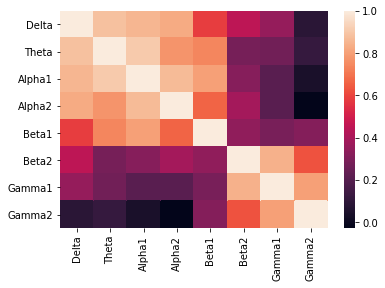

In [55]:
# Heat map
sns.heatmap(df[predictors].corr()) #vmin=0, vmax=1)

#### 2. Determine the most correlated predictors (call then A and B)
#### 3. calculate the average correlation between A and all other predictors and same for B
#### 4. remove the predictor with the largest average correlation
#### 5. Repeat steps 2-4 until the most correlated predictors are below a threshold correlation

Steps 2 to 5 are implemented in the next functions:

<p style="color:red">It would have been okay to choose predictors to remove b visual inspection. However this systematic approach is of course very nice.</p>

In [56]:
def get_most_correlated_predictors(corr_matrix):
    
    predictor_A = ''
    predictor_B = ''
    most_correlation_value = 0
    
    for rowA in corr_matrix:
        for i in range(len(corr_matrix[rowA])):       
            if corr_matrix[rowA][i] > most_correlation_value and corr_matrix[rowA][i] != 1:
                most_correlation_value = corr_matrix[rowA][i]
                predictor_A = rowA
                predictor_B = corr_matrix.columns[i]

    return predictor_A, predictor_B, most_correlation_value

def get_average_correlation_value(corr_matrix, predictor_A, predictor_B):  
    
    total_correlation_value_A = 0
    total_correlation_value_B = 0
    
    for row in corr_matrix:
        if predictor_A == row:
            diff = 0
            for i in range(len(corr_matrix[row])):                
                diff = diff + corr_matrix[row][i]
            total_correlation_value_A = total_correlation_value_A + diff/len(corr_matrix[row])

        if predictor_B == row:
            diff = 0
            for i in range(len(corr_matrix[row])):                
                diff = diff + corr_matrix[row][i]
            total_correlation_value_B = total_correlation_value_B + diff/len(corr_matrix[row])

    average_val_A = total_correlation_value_A
    average_val_B = total_correlation_value_B
    
    return average_val_A, average_val_B

def remove_correlated_predictors(corr_matrix):
    
    dropped_predictors = ''
    left_predictors = ''
    
    predictor_A, predictor_B, most_correlation_value = get_most_correlated_predictors(corr_matrix)
    
    average_val_A, average_val_B = get_average_correlation_value(corr_matrix, predictor_A, predictor_B)
    
    print('\nMost Correlated Predictors: {} - {}\n'.format(predictor_A, predictor_B))
    print('Most Correlated Predictors Value: {}\n'.format(most_correlation_value))
    print('Average Correlation Between Other Predictors for {}: {}\n'.format(predictor_A, average_val_A))
    print('Average Correlation Between Other Predictors for {}: {}\n'.format(predictor_B, average_val_B))
    
    if average_val_A > average_val_B:    
        dropped_predictors = predictor_A
#         corr_matrix = corr_matrix.drop([5], axis=0)
        corr_matrix = corr_matrix.drop([predictor_A], axis=1)
        left_predictors = predictor_B
    else:
        dropped_predictors = predictor_B
#         corr_matrix = corr_matrix.drop([5], axis=0)
        corr_matrix = corr_matrix.drop([predictor_B], axis=1)
        left_predictors = predictor_A
    
    print('Dropped Predictor: {}\n'.format(dropped_predictors))
    
    
    return left_predictors, dropped_predictors, most_correlation_value

In [57]:
sub_class = df[predictors]
most_correlation_value = 1
threshold = 0.90 # setting a threshold of correlations
while True:    
    corr_matrix =  sub_class.corr().abs()
    left_predictors, dropped_predictors, most_correlation_value = remove_correlated_predictors(corr_matrix)
    if most_correlation_value < threshold:
        break
    sub_class = sub_class.drop([dropped_predictors], axis=1)
print('Left predictors: {}'.format(sub_class.columns))

# Get the left predictors
predictors_new = sub_class.columns


Most Correlated Predictors: Theta - Alpha1

Most Correlated Predictors Value: 0.9115573889473185

Average Correlation Between Other Predictors for Theta: 0.6229573729222059

Average Correlation Between Other Predictors for Alpha1: 0.6264410916499601

Dropped Predictor: Alpha1


Most Correlated Predictors: Delta - Theta

Most Correlated Predictors Value: 0.8847176596087546

Average Correlation Between Other Predictors for Delta: 0.5992693422900264

Average Correlation Between Other Predictors for Theta: 0.5817287992043327

Dropped Predictor: Delta

Left predictors: Index(['Delta', 'Theta', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2'], dtype='object')


Using that algorithm, the left predictors are: `['Delta', 'Theta', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']`

In [92]:
acc_mean_E4, acc_sd_E4 = model_repeatedKfolds(predictors=df[predictors_new], target=df[target], K=9, n_repeats=10, model_type='logreg', result_type='on_testset')

logreg: Accuracy of k-means cross validation with 9 folds on test data:
	mean = 0.5777777777777777
	standard deviation = 0.12432087676452665


<p style="color:red">Comment on result missing -0.5</p>

### E5. Does skewness correction of predictors improve accuracy?

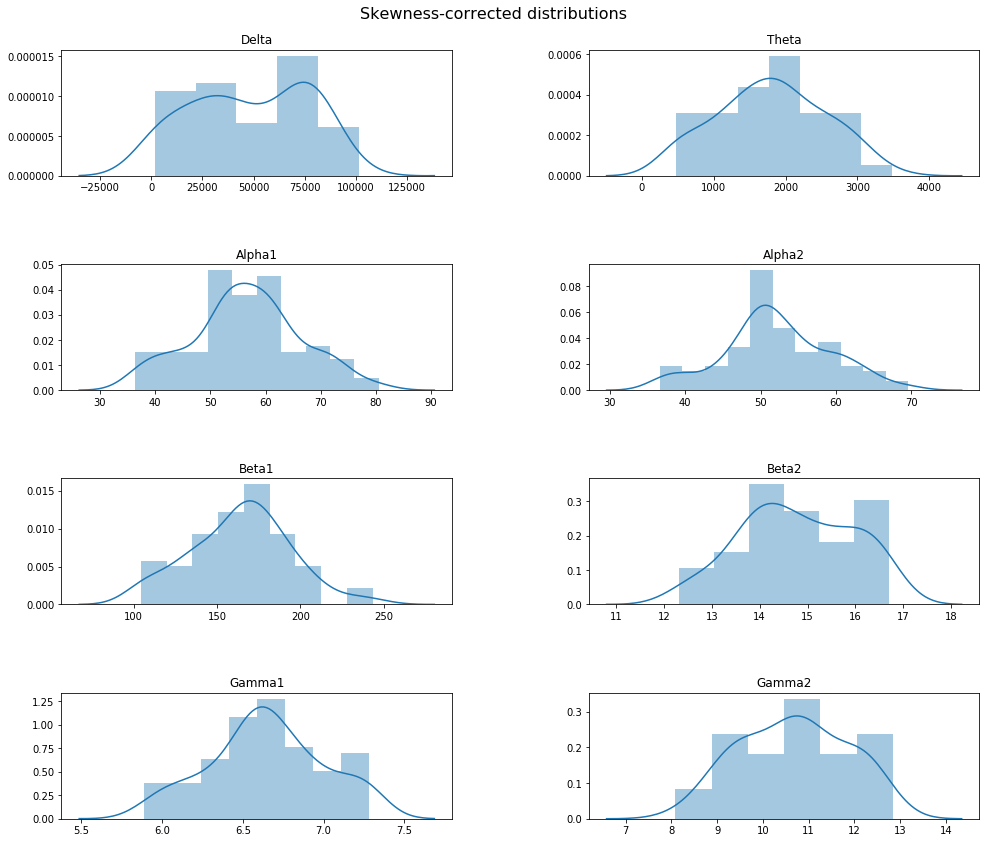

In [59]:
# New DataFrame to save unskewed data
df_unskewed = df.copy()

# Box-Cox
BC = np.zeros((90, len(predictors)))
plt.figure(figsize=(15, 12))
plt.suptitle('Skewness-corrected distributions', fontsize=16, y=1.02)
for i in range(len(predictors)):
    # Compute Box-Cox
    predictor_i = df[predictors].columns[i]
    lmbda_i = stats.boxcox_normmax(df[predictor_i])
    BC[:,i] = boxcox1p(df[predictor_i], lmbda_i)
    df_unskewed[predictor_i] = BC[:,i] 
    # skewness-corrected density distributions
    plt.subplot(4,2,i+1)
    sns.distplot(BC[:,i])
    plt.title(df[predictors].columns[i])
plt.subplots_adjust(top=0.97, bottom=0.08, left=0.10, right=0.95, hspace=0.7, wspace=0.35)

All predictor distributions look properly unskewed.

In [60]:
acc_mean_E5, acc_sd_E5 = model_repeatedKfolds(predictors=df_unskewed[predictors], target=df['ReportedConfusion'], K=9, n_repeats=10, model_type='logreg', result_type='on_testset')

logreg: Accuracy of k-means cross validation with 9 folds on test data:
	mean = 0.6311111111111111
	standard deviation = 0.1303792604694064


<p style="color:red">Comment on result missing -0.5</p>

## 2. Linear and quadratic discriminant analysis 


### E6. For skewed data

In [79]:
_, _ = model_repeatedKfolds(predictors=df[predictors], target=df[target], K=9, n_repeats=10, model_type='logreg', result_type='on_testset')
acc_mean_E6_linear, acc_sd_E6_linear = model_repeatedKfolds(predictors=df[predictors], target=df[target], K=9, n_repeats=10, model_type='linear', result_type='on_testset')
acc_mean_E6_quadratic, acc_sd_E6_quadratic = model_repeatedKfolds(predictors=df[predictors], target=df[target], K=9, n_repeats=10, model_type='quadratic', result_type='on_testset')

logreg: Accuracy of k-means cross validation with 9 folds on test data:
	mean = 0.5688888888888889
	standard deviation = 0.13209159610965607
linear: Accuracy of k-means cross validation with 9 folds on test data:
	mean = 0.6366666666666666
	standard deviation = 0.13694089596889616
quadratic: Accuracy of k-means cross validation with 9 folds on test data:
	mean = 0.5777777777777778
	standard deviation = 0.14593963487933667


Comparing the means, we conclude that LDA (Linear Discriminant Analysis) is giving the best accuracy. Next comes Logistic Regression. The last and worst with much difference is the QDA (Quadratic Discriminant Analysis).

<p style="color:red">Differences between LDA/QDA and LDA/LR? Which method would you prefer? -1</p>

### E7. For unskewed data

In [81]:
_, _ = model_repeatedKfolds(predictors=df_unskewed[predictors], target=df[target], K=9, n_repeats=10, model_type='logreg', result_type='on_testset')
acc_mean_E7_linear, acc_sd_E7_linear = model_repeatedKfolds(predictors=df_unskewed[predictors], target=df[target], K=9, n_repeats=10, model_type='linear', result_type='on_testset')
acc_mean_E7_quadratic, acc_sd_E7_quadratic = model_repeatedKfolds(predictors=df_unskewed[predictors], target=df[target], K=9, n_repeats=10, model_type='quadratic', result_type='on_testset')

logreg: Accuracy of k-means cross validation with 9 folds on test data:
	mean = 0.6311111111111111
	standard deviation = 0.1303792604694064
linear: Accuracy of k-means cross validation with 9 folds on test data:
	mean = 0.6844444444444444
	standard deviation = 0.1331646873519893
quadratic: Accuracy of k-means cross validation with 9 folds on test data:
	mean = 0.5233333333333333
	standard deviation = 0.16628795925519813


Using the unskewed data to train our models improve the accuracy for the Logistic Regression and for LDA. Opposielly, the QDA accuracy gets worse.

## 3. Better preprocessing makes a better classifier

### E8. Base-line correction

In [63]:
data_bc_raw = df.copy()
data_bc = pd.DataFrame()

predictors = ['Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']
# apply baseline correction
for (SubjectID), subjectdata in data_bc_raw.groupby(('SubjectID')): # first by subject
    for i in predictors:
        mean = np.mean(subjectdata[i]) # then by predictor
        subjectdata[i] = subjectdata[i] - mean
    data_bc = pd.concat([data_bc,subjectdata],ignore_index=True)

x_data_bc = data_bc[predictors]

C:\Users\guill\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [75]:
print('Logistic regression on baseline corrected data')
acc_mean_E8_logreg, acc_sd_E8_logreg = model_repeatedKfolds(predictors=x_data_bc, target=data['ReportedConfusion'], K=10, n_repeats=10, model_type='logreg', result_type='on_testset')
print('\nLinear discriminant analysis on baseline corrected data')
acc_mean_E8_linear, acc_sd_E8_linear = model_repeatedKfolds(predictors=x_data_bc, target=data['ReportedConfusion'], K=10, n_repeats=10, model_type='linear', result_type='on_testset')
print('\nQuadratic discriminant analysis on baseline corrected data')
acc_mean_E8_quadratic, acc_sd_E8_quadratic = model_repeatedKfolds(predictors=x_data_bc, target=data['ReportedConfusion'], K=10, n_repeats=10, model_type='quadratic', result_type='on_testset')

Logistic regression on baseline corrected data
logreg: Accuracy of k-means cross validation with 10 folds on test data:
	mean = 0.8555555555555556
	standard deviation = 0.1238489842272695

Linear discriminant analysis on baseline corrected data
linear: Accuracy of k-means cross validation with 10 folds on test data:
	mean = 0.8588888888888887
	standard deviation = 0.1158958556540107

Quadratic discriminant analysis on baseline corrected data
quadratic: Accuracy of k-means cross validation with 10 folds on test data:
	mean = 0.7888888888888889
	standard deviation = 0.13070740029482608


Correcting the base-line improves the accuracy significantly.

### E9. Summary

In [97]:
class color:
    BOLD = '\033[1m'
    END = '\033[0m'

table = [
    ["", "Model", "Predictors", "PredAcc", "PredAccSD"],
    ["1", 'Logistic regression training', 'All 8 EEG power bands', round(acc_mean_E2,3), '-'],
    ["2", 'Logistic regression 10-fold CV', 'All 8 EEG power bands', round(acc_mean_E3,3), round(acc_sd_E3,3)],
    ["3", 'Logistic regression', 'Removed Alpha1', round(acc_mean_E4,3),  round(acc_sd_E4,3)],
    ["4", 'Logistic regression 10-fold CV', 'All 8 EEG power bands unskewed', round(acc_mean_E5,3),  round(acc_sd_E5,3)],
    ["5", 'Linear Discriminant Analysis', 'All 8 EEG power bands', round(acc_mean_E6_linear,3),  round(acc_sd_E6_linear,3)],
    ["6", 'Quadratic Discriminant Analysis', 'All 8 EEG power bands', round(acc_mean_E6_quadratic,3),  round(acc_sd_E6_quadratic,3)],
    ["7", 'Linear Discriminant Analysis', 'All 8 EEG power bands unskewed', round(acc_mean_E7_linear,3),  round(acc_sd_E7_linear,3)],
    ["8", 'Quadratic Discriminant Analysis', 'All 8 EEG power bands unskewed', round(acc_mean_E7_quadratic,3),  round(acc_sd_E7_quadratic,3)],
    ["9", 'Logistic regression', 'All 8 EEG power bands mean subtracted', round(acc_mean_E8_logreg,3),  round(acc_sd_E8_logreg,3)],
    ["10", 'Linear Discriminant Analysis', 'All 8 EEG power bands mean subtracted', round(acc_mean_E8_linear,3),  round(acc_sd_E8_linear,3)],
    ["11", 'Quadratic Discriminant Analysis', 'All 8 EEG power bands mean subtracted', round(acc_mean_E8_quadratic,3),  round(acc_sd_E8_quadratic,3)],
]
def print_table(table):
    longest_cols = [
        (max([len(str(row[i])) for row in table]) + 3)
        for i in range(len(table[0]))
    ]
    row_format = "".join(["{:>" + str(longest_col) + "}" for longest_col in longest_cols])
    i = 0
    for row in table:
        if i == 0:
            print(color.BOLD + row_format.format(*row) + color.END)
            print('------------------------------------------------------------------------------------------------------------------')
        else:
            print(row_format.format(*row))
        i = i +1
    
print_table(table)

                                  Model                              Predictors   PredAcc   PredAccSD
------------------------------------------------------------------------------------------------------------------
    1      Logistic regression training                   All 8 EEG power bands     0.622           -
    2    Logistic regression 10-fold CV                   All 8 EEG power bands      0.57       0.158
    3               Logistic regression                          Removed Alpha1     0.578       0.124
    4    Logistic regression 10-fold CV          All 8 EEG power bands unskewed     0.631        0.13
    5      Linear Discriminant Analysis                   All 8 EEG power bands     0.637       0.137
    6   Quadratic Discriminant Analysis                   All 8 EEG power bands     0.578       0.146
    7      Linear Discriminant Analysis          All 8 EEG power bands unskewed     0.684       0.133
    8   Quadratic Discriminant Analysis          All 8 EEG power band

QUESTIONS:

Is it really correct to compute accuracy using the training set? We are asked to do so in E2 because we use all the data for training and then we're not left with any data to test.

<p style="color:red">E2 was just to show that testing on your training set is not a good idea. When using k-fold cross validation training/test splits are done right</p>